# End-to-End Pipeline: Multimodal Property Valuation

This notebook implements a Fusion Neural Network that combines structured tabular data (specifications) with unstructured satellite imagery to predict property prices. We benchmark this against a Random Forest baseline.

In [6]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
warnings.filterwarnings('ignore')

# Style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'sans-serif'

# Config
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
EPOCHS = 20
LEARNING_RATE = 1e-4
PROCESSED_DIR = "../data/processed"
IMAGE_DIR = "../data/images"
OUTPUT_DIR = "../outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Using Device: {DEVICE}")

Using Device: cpu


## 1. Establishing the Baseline (Random Forest)
Before deploying deep learning, we assess how well a traditional algorithm performs on tabular data alone.

In [7]:
# Load Data
train_df = pd.read_csv(os.path.join(PROCESSED_DIR, "train.csv"))
val_df = pd.read_csv(os.path.join(PROCESSED_DIR, "val.csv"))

feature_cols = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 
                'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 
                'yr_built', 'yr_renovated', 'lat', 'long', 'sqft_living15', 
                'sqft_lot15', 'house_age', 'zipcode_mean']

# Target Statistics (Critical for Neural Network Scaling)
y_mean = train_df['price_log'].mean()
y_std = train_df['price_log'].std()

# Save Stats
with open(os.path.join(OUTPUT_DIR, "target_norm.json"), 'w') as f:
    json.dump({"mean": y_mean, "std": y_std}, f)

# Train Random Forest
print("Training Baseline Random Forest...")
rf = RandomForestRegressor(n_estimators=500, max_depth=20, n_jobs=-1, random_state=42)
rf.fit(train_df[feature_cols], train_df['price_log'])
baseline_r2 = r2_score(val_df['price_log'], rf.predict(val_df[feature_cols]))

print(f"Baseline Random Forest R2: {baseline_r2:.4f}")
print(f"Target Normalization: Mean={y_mean:.4f}, Std={y_std:.4f}")

Training Baseline Random Forest...
Baseline Random Forest R2: 0.7949
Target Normalization: Mean=13.0536, Std=0.5034


## 2. Neural Network Architecture (Fusion Model)
We fuse a **ResNet-18** (for images) with a Multi-Layer Perceptron (for tabular specs).

**Performance Strategy**: We utilize a transfer learning approach. The ResNet backbone is initially frozen to allow the custom heads to learn, then unfrozen for fine-tuning.

In [8]:
# Dataset Class
class PropertyDataset(Dataset):
    def __init__(self, df, img_dir, mean, std, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.mean = mean
        self.std = std
        self.transform = transform
        self.features = feature_cols
        
    def __len__(self): return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, f"{int(row['id'])}.png")
        try: 
            image = Image.open(img_path).convert('RGB')
        except: 
            image = Image.new('RGB', (224, 224))
            
        if self.transform: image = self.transform(image)
        
        tabular = torch.tensor(row[self.features].values.astype(np.float32))
        target = (row['price_log'] - self.mean) / self.std # Standardization
        return image, tabular, torch.tensor(target, dtype=torch.float32)

# Transforms
train_tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
])
val_tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Model Definition
class FusionModel(nn.Module):
    def __init__(self, fine_tune=False):
        super().__init__()
        # Vision Branch (ResNet18)
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        
        if not fine_tune:
            for param in self.resnet.parameters():
                param.requires_grad = False
        
        self.resnet.fc = nn.Identity() # Remove classification head
        
        # Tabular Branch (MLP)
        self.mlp = nn.Sequential(
            nn.Linear(len(feature_cols), 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        
        # Fusion Layer
        self.head = nn.Sequential(
            nn.Linear(512 + 64, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )
        
    def forward(self, img, tab):
        v = self.resnet(img)
        t = self.mlp(tab)
        return self.head(torch.cat((v, t), dim=1))

    def set_fine_tune(self, fine_tune):
        for param in self.resnet.parameters():
            param.requires_grad = fine_tune

print("Fusion Architecture Defined.")

Fusion Architecture Defined.


## 3. Training Protocol

In [9]:
# Loaders
train_loader = DataLoader(PropertyDataset(train_df, IMAGE_DIR, y_mean, y_std, train_tfm), 
                          batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(PropertyDataset(val_df, IMAGE_DIR, y_mean, y_std, val_tfm), 
                        batch_size=BATCH_SIZE)

# Setup
model = FusionModel(fine_tune=False).to(DEVICE)
criterion = nn.MSELoss()

# Optimizer strategy: Initially train only heads
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)

# Training Loop
history = {'train_loss': [], 'val_r2': []}
best_r2 = -float('inf')

print("Starting DL Training...")
for epoch in range(EPOCHS):
    
    # Fine-tuning Strategy: Unfreeze ResNet after 5 epochs
    if epoch == 5:
        print("Unfreezing ResNet Weights...")
        model.set_fine_tune(True)
        # Lower LR for fine-tuning entire network
        optimizer = optim.AdamW(model.parameters(), lr=1e-4)
    
    # Train
    model.train()
    epoch_loss = 0
    for imgs, tabs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False):
        imgs, tabs, targets = imgs.to(DEVICE), tabs.to(DEVICE), targets.to(DEVICE)
        
        optimizer.zero_grad()
        preds = model(imgs, tabs).squeeze()
        loss = criterion(preds, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    history['train_loss'].append(epoch_loss / len(train_loader))
    
    # Validate
    model.eval()
    preds, actuals = [], []
    with torch.no_grad():
        for imgs, tabs, targets in val_loader:
            out = model(imgs.to(DEVICE), tabs.to(DEVICE)).squeeze().cpu()
            preds.extend((out * y_std + y_mean).numpy())
            actuals.extend((targets * y_std + y_mean).numpy())
            
    val_r2 = r2_score(actuals, preds)
    history['val_r2'].append(val_r2)
    
    # Step scheduler
    scheduler.step(val_r2)
    
    if val_r2 > best_r2:
        best_r2 = val_r2
        torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, "best_model.pth"))
        print(f"Epoch {epoch+1}: Val R2={val_r2:.4f} (Saved)")
    else:
        print(f"Epoch {epoch+1}: Val R2={val_r2:.4f}")

print(f"Final Best DL R2: {best_r2:.4f}")

Starting DL Training...


Epoch 1/20:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 1: Val R2=0.6404 (Saved)


Epoch 2/20:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 2: Val R2=0.8250 (Saved)


Epoch 3/20:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 3: Val R2=0.7567


Epoch 4/20:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 4: Val R2=0.7604


Epoch 5/20:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 5: Val R2=0.8119
Unfreezing ResNet Weights...


Epoch 6/20:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 6: Val R2=0.7985


Epoch 7/20:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 7: Val R2=0.8160


Epoch 8/20:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 8: Val R2=0.7868


Epoch 9/20:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 9: Val R2=0.7848


Epoch 10/20:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 10: Val R2=0.7598


Epoch 11/20:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 11: Val R2=0.8038


Epoch 12/20:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 12: Val R2=0.7981


Epoch 13/20:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 13: Val R2=0.7955


Epoch 14/20:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 14: Val R2=0.7605


Epoch 15/20:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 15: Val R2=0.7887


Epoch 16/20:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 16: Val R2=0.7666


Epoch 17/20:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 17: Val R2=0.7903


Epoch 18/20:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 18: Val R2=0.7910


Epoch 19/20:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 19: Val R2=0.7968


Epoch 20/20:   0%|          | 0/51 [00:00<?, ?it/s]

Epoch 20: Val R2=0.7885
Final Best DL R2: 0.8250


## 4. INFERENCE & MODEL COMPARISON

In [10]:
# --- 1. Load Best Saved Model ---
print("\nLoading Best Saved Model...")
model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, "best_model.pth")))
model.eval()

# --- 2. Run Inference on Validation Set ---
print("Running Inference on Validation Set...")
val_preds = []
val_actuals = []

with torch.no_grad():
    for imgs, tabs, targets in val_loader:
        imgs, tabs = imgs.to(DEVICE), tabs.to(DEVICE)
        outputs = model(imgs, tabs).squeeze().cpu().numpy()
        val_preds.extend(outputs)
        val_actuals.extend(targets.numpy())

# --- 3. Inverse Transform Targets ---
val_preds = np.array(val_preds) * y_std + y_mean
val_actuals = np.array(val_actuals) * y_std + y_mean

# --- 4. Calculate Metrics ---
final_r2 = r2_score(val_actuals, val_preds)
final_mse = mean_squared_error(val_actuals, val_preds)

print(f"Final Validation R2: {final_r2:.4f}")
print(f"Final Validation MSE: {final_mse:.4f}")

# --- 5. Comparison Plot ---
results_df = pd.DataFrame({
    'Model': ['Baseline (RF)', 'Multimodal (Fusion)'],
    'R2 Score': [baseline_r2, final_r2]
})

print("\n" + "="*40)
print(f"       FINAL MODEL COMPARISON       ")
print("="*40)
print(results_df.to_string(index=False))
print("-"*40)
improvement = (final_r2 - baseline_r2) / baseline_r2 * 100
print(f"Improvement: {improvement:.2f}%")


Loading Best Saved Model...
Running Inference on Validation Set...
Final Validation R2: 0.8250
Final Validation MSE: 0.0455

       FINAL MODEL COMPARISON       
              Model  R2 Score
      Baseline (RF)  0.794858
Multimodal (Fusion)  0.824993
----------------------------------------
Improvement: 3.79%



Generating Grad-CAM Visualization...


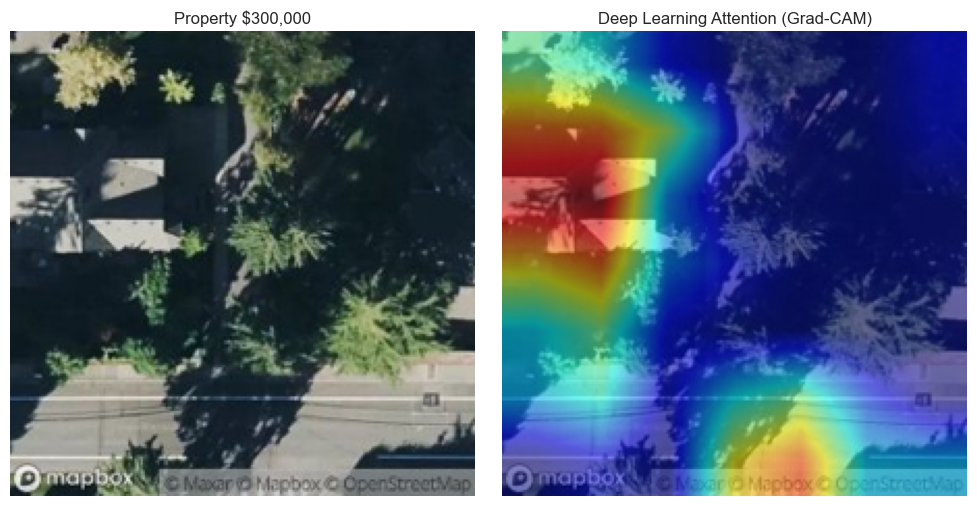

In [11]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image

print("\nGenerating Grad-CAM Visualization...")

# 1. Wrapper to make model compatible with Grad-CAM
class ModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        # Create dummy tabular input (zeros) just to satisfy the forward pass
        # Grad-CAM only cares about the image gradients here
        dummy_tab = torch.zeros((x.size(0), len(feature_cols))).to(x.device)
        return self.model(x, dummy_tab)

wrapped_model = ModelWrapper(model)
target_layers = [model.resnet.layer4[-1]] # Target the last ResNet layer

# 2. Select a Sample Image
sample_idx = 0
sample_row = val_df.iloc[sample_idx]
img_path = os.path.join(IMAGE_DIR, f"{int(sample_row['id'])}.png")

try:
    # Prepare Image
    rgb_img = Image.open(img_path).convert('RGB')
    rgb_img = rgb_img.resize((224, 224))
    input_tensor = val_tfm(rgb_img).unsqueeze(0).to(DEVICE)
    rgb_img_np = np.float32(rgb_img) / 255 # Normalize for display

    # 3. Generate CAM
    cam = GradCAM(model=wrapped_model, target_layers=target_layers)
    grayscale_cam = cam(input_tensor=input_tensor)[0]
    visualization = show_cam_on_image(rgb_img_np, grayscale_cam, use_rgb=True)

    # 4. Plot
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(rgb_img)
    plt.title(f"Property ${sample_row['price']:,.0f}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(visualization)
    plt.title("Deep Learning Attention (Grad-CAM)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Could not generate Grad-CAM: {e}")
    print("Ensure pytorch-grad-cam is installed (pip install grad-cam) and the image path exists.")